# Special loss function

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import wandb

import utils

In [2]:
plt.style.use('bmh')

In [3]:
rng = np.random.default_rng(2)

if torch.cuda.is_available():
    DEVICE = 'cuda'
    accelerator='gpu'
else:
    DEVICE = 'cpu'
    accelerator='cpu'

## Training and test data

### Create synthetic data

In [4]:
rng = np.random.default_rng(0)

N_SAMPLES = 25000

# Features randomly distributed
xvals = np.sort(rng.random(N_SAMPLES))

# Symmetric noise
envelope = 0.25 * np.abs(np.cos(xvals * 1.75 * np.pi))
noise = envelope * rng.normal(loc=0, scale=1, size=N_SAMPLES)
# Labels
meanvals = 2 * xvals + 0.5 * np.sin(3 * xvals * np.pi) + 1

# meanvals = np.zeros(N_SAMPLES)
yvals = meanvals + noise

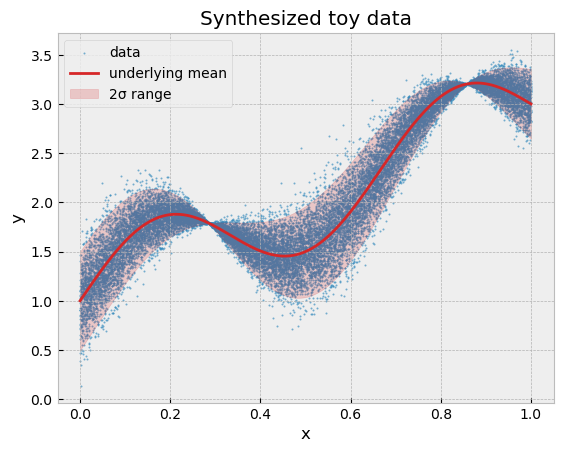

In [5]:
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, s=1, alpha=0.5, label='data')
ax.set(xlabel='x', ylabel='y', title='Synthesized toy data');
ax.plot(xvals, meanvals, color='tab:red', label='underlying mean')
ax.fill_between(
    xvals, meanvals + 2*envelope, meanvals - 2*envelope, alpha=0.2,
    color='tab:red', label='2\u03C3 range'
)
ax.legend()

### Split into training and testing data

In [6]:
frac = 0.8
xvals = xvals.reshape(-1,1)
yvals = yvals.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(xvals, yvals, train_size=frac, random_state=0)

In [7]:
# Sort values for plotting ease later
train_sort_indices = np.argsort(x_train, axis=0).squeeze()
x_train = x_train[train_sort_indices]
y_train = y_train[train_sort_indices]

test_sort_indices = np.argsort(x_test, axis=0).squeeze()
x_test = x_test[test_sort_indices]
y_test = y_test[test_sort_indices]

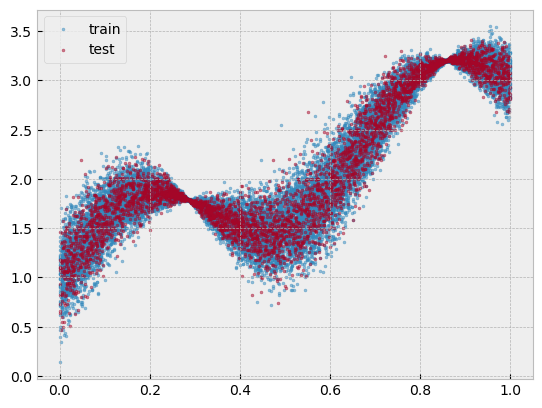

In [8]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, s=4, alpha=0.5, label='train')
ax.scatter(x_test, y_test, s=4, alpha=0.5, label='test')
ax.legend();

### Create Tensors

In [9]:
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(x_test).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

In [10]:
if torch.cuda.is_available():
    print('Using CUDA')
    x_train = x_train.to('cuda')
    y_train = y_train.to('cuda')
    x_test = x_test.to('cuda')
    y_test = y_test.to('cuda')
else:
    print('CUDA not available')

x_train.device

CUDA not available


device(type='cpu')

### Create Dataset

In [11]:
train_ds = utils.ToyDataset(x_train, y_train)
test_ds = utils.ToyDataset(x_test, y_test)

### Create DataLoader

In [12]:
batch_size = 32

In [13]:
# Create dataloaders
train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
)

# Create ANN with regular Gaussian negative likelihood loss

In [14]:
configs = dict(
    network_architecture=[10, 10],
    lr=1e-3,
    optimizer='Adam',
    loss_func='GaussianNLLLoss',
    l2=0.0,
    epochs=1000,
    early_stopping=True,
    patience=20,
    std_switch=False,
    batch_size=batch_size,
    seed=0
)

In [15]:
n_inputs = 1
model = utils.ANN(n_inputs, configs)

Global seed set to 0


## Create trainer

### Create callbacks

In [16]:
def get_callbacks(configs):
    callbacks = []
    if configs['std_switch']:
        monitor = 'val/GaussianNLL'
        switch_callback = utils.LogLikelihoodSwitch(
            monitor=monitor,
            patience=configs['patience'],
            mode='min'
        )
        callbacks.append(switch_callback)
        
    if configs['early_stopping']:
        monitor = 'val/GaussianNLL'        
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=monitor,
            patience=configs['patience'] + 1, 
            mode='min'
        )
        callbacks.append(early_stop_callback)
    return callbacks

callbacks = get_callbacks(configs)

In [17]:
callbacks

### Logger

In [18]:
name = 'unfrozen_std'
logger = pl.loggers.CSVLogger('logger', name=name)

### Build trainer

In [19]:
trainer = pl.Trainer(
    logger=logger,
    accelerator=accelerator,
    max_epochs=configs['epochs'],
    callbacks=callbacks,
    enable_progress_bar=False,
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


## Training loop

In [20]:
%%time
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader
)

Missing logger folder: logger/unfrozen_std

  | Name    | Type            | Params
--------------------------------------------
0 | stack   | Sequential      | 152   
1 | loss_fn | GaussianNLLLoss | 0     
--------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, d

CPU times: user 2min 32s, sys: 507 ms, total: 2min 32s
Wall time: 2min 33s


## Analysis

In [21]:
# Set model to evaluation mode
model.eval()

ANN(
  (stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (loss_fn): GaussianNLLLoss()
)

In [22]:
model(next(iter(train_dataloader))[0].float())[0:5,:]

tensor([[ 2.9048, -4.2300],
        [ 3.1855, -4.5647],
        [ 1.5328, -2.7695],
        [ 1.4621, -2.3129],
        [ 1.3692, -1.7120]], grad_fn=<SliceBackward0>)

In [23]:
metrics = pd.read_csv('logger/unfrozen_std/version_0/metrics.csv')

# Take average over each epoch
df = metrics.groupby('epoch').mean()
df.tail()

,val/GaussianNLL,val/MSE,step,train/GaussianNLL,train/MSE
epoch,,,,,
293,-1.349668,0.033075,183749.0,-1.361346,0.034263
294,-1.373438,0.033250,184374.0,-1.360540,0.034285
295,-1.380805,0.032301,184999.0,-1.359931,0.034278
296,-1.382468,0.032540,185624.0,-1.361981,0.034192
297,-1.380771,0.032770,186249.0,-1.360725,0.034345


In [24]:
epochs = df.index
train_loss = df['train/GaussianNLL']
val_loss = df['val/GaussianNLL']

train_mse = df['train/MSE']
val_mse = df['val/MSE']

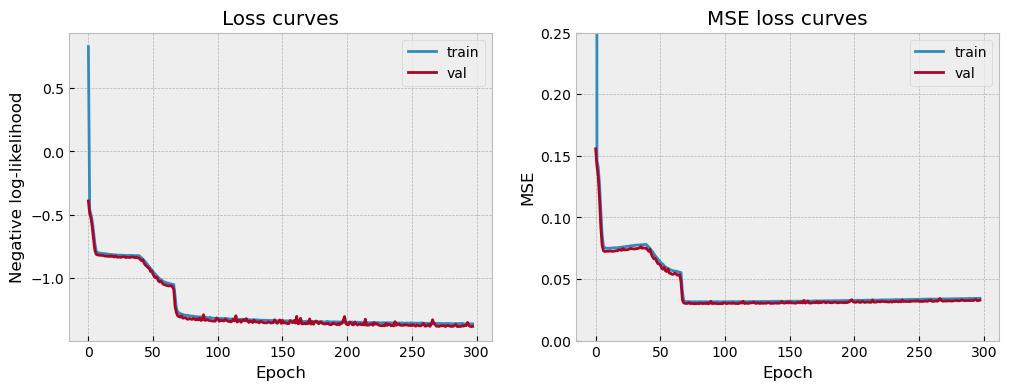

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
axes[0].plot(epochs, train_loss, label='train');
axes[0].plot(epochs, val_loss, label='val');
axes[0].set(
    title='Loss curves',
    xlabel='Epoch',
    ylabel='Negative log-likelihood'
)
axes[0].legend();
axes[1].plot(epochs, train_mse, label='train');
axes[1].plot(epochs, val_mse, label='val');
axes[1].set(
    title='MSE loss curves',
    xlabel='Epoch',
    ylabel='MSE',
    ylim=(0, 0.25)
)
axes[1].legend()

In [26]:
x_pred = x_test.cpu().squeeze().numpy()
y_pred = model(x_test.float()).cpu().detach().numpy().squeeze()

indices = x_test.flatten().numpy().argsort()
x_pred = x_pred[indices]
y_pred = y_pred[indices]

y_pred_mean = y_pred[:, 0]
y_pred_std = np.sqrt(np.exp(y_pred[:, 1]))

y_pred[0:5,:]

array([[ 1.3355258, -1.4945445],
       [ 1.3357334, -1.4958854],
       [ 1.3359325, -1.4971731],
       [ 1.3363881, -1.5001191],
       [ 1.3366375, -1.5017309]], dtype=float32)

[Text(0.5, 1.0, 'Distribution of true amplitudes'), (0.0, 0.5)]

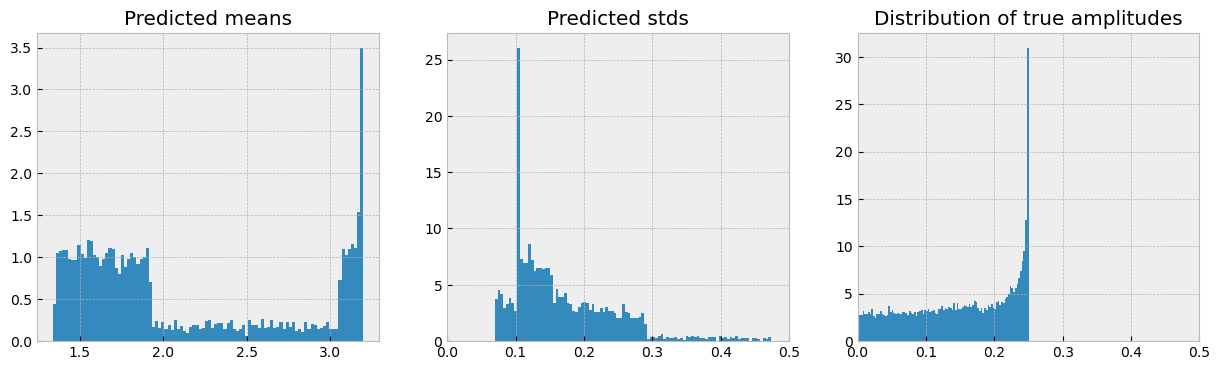

In [27]:
# Histogram of predicted values
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
axes[0].hist(y_pred_mean, bins=100, density=True);
axes[1].hist(y_pred_std, bins=100, density=True);
axes[2].hist(envelope, bins=100, density=True);

axes[0].set(title='Predicted means')
axes[1].set(title='Predicted stds', xlim=(0,0.5))
axes[2].set(title='Distribution of true amplitudes', xlim=(0,0.5))

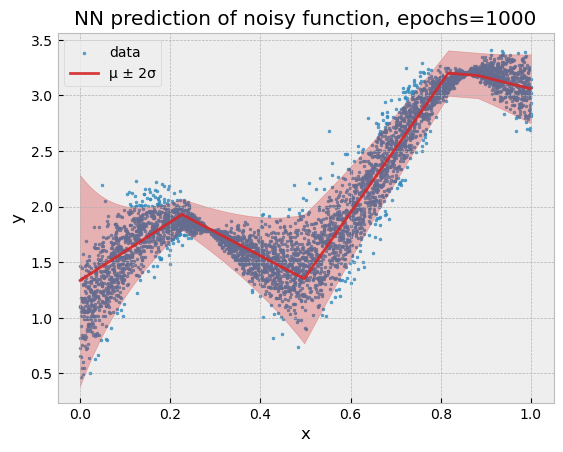

In [28]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, s=4, alpha=0.8, label='data');
ax.plot(x_pred, y_pred_mean, alpha=0.9, color='tab:red', label='\u03BC \u00B1 2\u03C3');
ax.fill_between(x_pred, y_pred_mean + 2*y_pred_std, y_pred_mean - 2*y_pred_std,
                color='tab:red', alpha=0.3);

ax.set(
    title='NN prediction of noisy function, epochs=1000',
    xlabel='x',
    ylabel='y'
);
ax.legend(loc='upper left');

# Alternative version: Freezing std until mean is trained, and then training on std

In [29]:
configs = dict(
    network_architecture=[10, 10],
    lr=1e-3,
    optimizer='Adam',
    loss_func='GaussianNLLLoss',
    l2=0.0,
    epochs=1000,
    early_stopping=True,
    patience=20,
    std_switch=True,
    batch_size=batch_size,
    seed=0
)

In [30]:
n_inputs = 1
model = utils.ANN(n_inputs, configs)

Global seed set to 0


## Create trainer

### Create callbacks

In [31]:
def get_callbacks(configs):
    callbacks = []
    if configs['std_switch']:
        monitor = 'val/GaussianNLL'
        switch_callback = utils.LogLikelihoodSwitch(
            monitor=monitor,
            patience=configs['patience'],
            mode='min'
        )
        callbacks.append(switch_callback)
        
    if configs['early_stopping']:
        monitor = 'val/GaussianNLL'        
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=monitor,
            patience=configs['patience'] + 1, 
            mode='min'
        )
        callbacks.append(early_stop_callback)
    return callbacks

callbacks = get_callbacks(configs)

In [32]:
callbacks

### Logger

In [33]:
name = 'unfrozen_std'
logger = pl.loggers.CSVLogger('logger', name=name)

### Build trainer

In [34]:
trainer = pl.Trainer(
    logger=logger,
    accelerator=accelerator,
    max_epochs=configs['epochs'],
    callbacks=callbacks,
    enable_progress_bar=False,
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


## Training loop

In [35]:
%%time
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader
)


  | Name    | Type            | Params
--------------------------------------------
0 | stack   | Sequential      | 152   
1 | loss_fn | GaussianNLLLoss | 0     
--------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bo

Switching training to train on mu and sigma (epoch 130
Switching training to train on mu and sigma (epoch 473
Switching training to train on mu and sigma (epoch 474
CPU times: user 4min 4s, sys: 762 ms, total: 4min 5s
Wall time: 4min 5s


## Analysis

In [36]:
# Set model to evaluation mode
model.eval()

ANN(
  (stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (loss_fn): GaussianNLLLoss()
)

In [37]:
model(next(iter(train_dataloader))[0].float())[0:5,:]

tensor([[ 1.2937, -2.0254],
        [ 1.6977, -3.6118],
        [ 1.7612, -2.7407],
        [ 1.5836, -4.4647],
        [ 2.0208, -3.0763]], grad_fn=<SliceBackward0>)

In [38]:
metrics = pd.read_csv('logger/unfrozen_std/version_0/metrics.csv')

# Take average over each epoch
df = metrics.groupby('epoch').mean()
df.tail()

,val/GaussianNLL,val/MSE,step,train/GaussianNLL,train/MSE
epoch,,,,,
293,-1.349668,0.033075,183749.0,-1.361346,0.034263
294,-1.373438,0.033250,184374.0,-1.360540,0.034285
295,-1.380805,0.032301,184999.0,-1.359931,0.034278
296,-1.382468,0.032540,185624.0,-1.361981,0.034192
297,-1.380771,0.032770,186249.0,-1.360725,0.034345


In [39]:
epochs = df.index
train_loss = df['train/GaussianNLL']
val_loss = df['val/GaussianNLL']

train_mse = df['train/MSE']
val_mse = df['val/MSE']

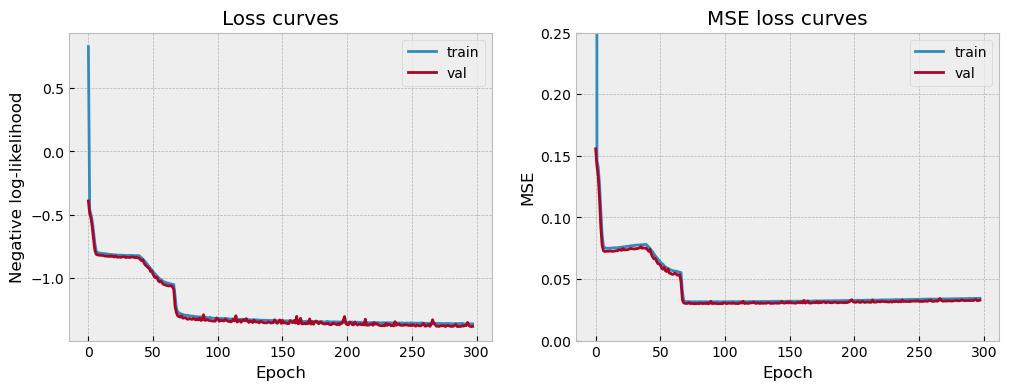

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
axes[0].plot(epochs, train_loss, label='train');
axes[0].plot(epochs, val_loss, label='val');
axes[0].set(
    title='Loss curves',
    xlabel='Epoch',
    ylabel='Negative log-likelihood'
)
axes[0].legend();
axes[1].plot(epochs, train_mse, label='train');
axes[1].plot(epochs, val_mse, label='val');
axes[1].set(
    title='MSE loss curves',
    xlabel='Epoch',
    ylabel='MSE',
    ylim=(0, 0.25)
)
axes[1].legend()

In [41]:
x_pred = x_test.cpu().squeeze().numpy()
y_pred = model(x_test.float()).cpu().detach().numpy().squeeze()

indices = x_test.flatten().numpy().argsort()
x_pred = x_pred[indices]
y_pred = y_pred[indices]

y_pred_mean = y_pred[:, 0]
y_pred_std = np.sqrt(np.exp(y_pred[:, 1]))

y_pred[0:5,:]

array([[ 1.2417853, -1.8416252],
       [ 1.241821 , -1.8417492],
       [ 1.2418556, -1.8418684],
       [ 1.2419343, -1.8421407],
       [ 1.2419775, -1.8422899]], dtype=float32)

[Text(0.5, 1.0, 'Distribution of true amplitudes'), (0.0, 0.5)]

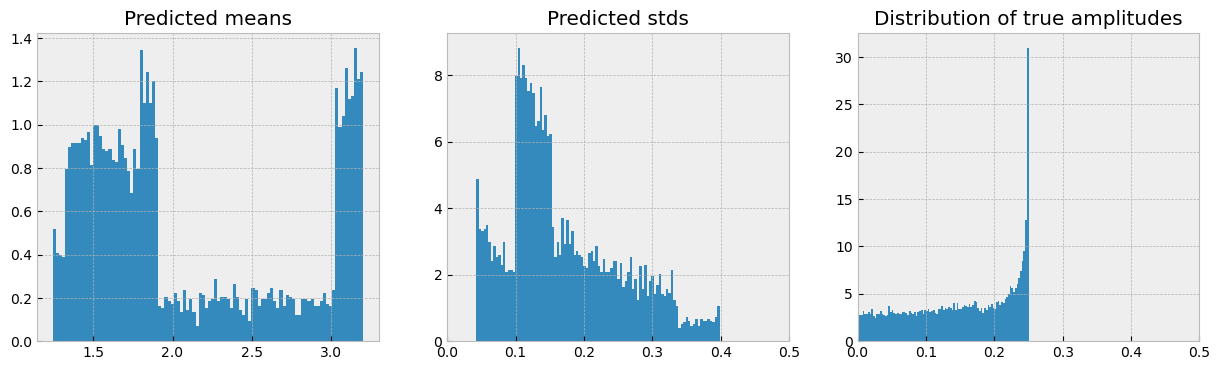

In [42]:
# Histogram of predicted values
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
axes[0].hist(y_pred_mean, bins=100, density=True);
axes[1].hist(y_pred_std, bins=100, density=True);
axes[2].hist(envelope, bins=100, density=True);

axes[0].set(title='Predicted means')
axes[1].set(title='Predicted stds', xlim=(0,0.5))
axes[2].set(title='Distribution of true amplitudes', xlim=(0,0.5))

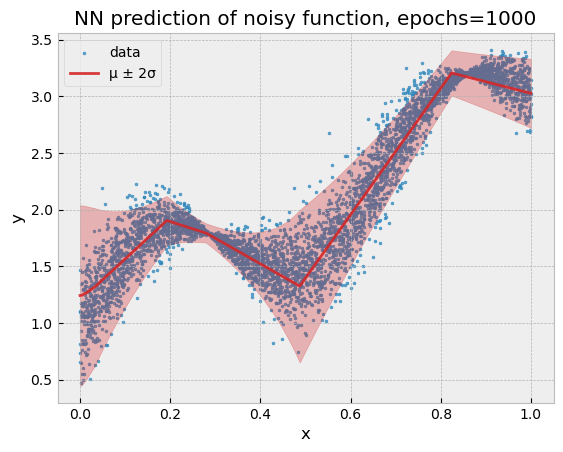

In [43]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, s=4, alpha=0.8, label='data');
ax.plot(x_pred, y_pred_mean, alpha=0.9, color='tab:red', label='\u03BC \u00B1 2\u03C3');
ax.fill_between(x_pred, y_pred_mean + 2*y_pred_std, y_pred_mean - 2*y_pred_std,
                color='tab:red', alpha=0.3);

ax.set(
    title='NN prediction of noisy function, epochs=1000',
    xlabel='x',
    ylabel='y'
);
ax.legend(loc='upper left');

In [44]:
model.freeze_std

False

In [46]:
trainer.callbacks[0].switched_epoch

474

---